# Unemployment
<i> Authors: Markus Viljanen </i>

This notebook is a simple illustration of machine learning models that predict unemployment. Unemployment has been traditionally studied in two ways. First, macroeconometric labour market statistics provide an overview of the unemployment rate but do not consider how individuals experience different amounts of unemployment. Microeconometric studies have been performed to assess the impact of government policies and individual’s characteristics on unemployment, typically on the length of unemployment spells. Machine learning has become increasingly popular in many fields because it has enabled more accurate predictions. Unemployment therefore seems like a natural application of machine learning: there are well-formulated prediction tasks that require accurate answers. 

We fit models to a data set of unemployment histories, where the goal is to predict the following at different months:
1. Who is at the highest risk of exiting unemployment?
2. Who is at the highest risk of entering unemployment?
3. Who is at the highest risk of being unemployed?

The data set is based on a sample of the local unemployment registry, where practically all unemployed people are registered. The person identifiers in the data set are anonymized and the persons are described by a set of generic features. The resulting  predictions are based on two information sources about the person: features and their past unemployment history. The model is able to learn the effect of 'missing features', such as features we did not include or different motivations in finding a job, by observing how the persons have been unemployed in the past.

This notebook is a more 'hacky' version of our paper, since it aims to illustrate a simpler version of the model without giving too much attention to the mathematical details. The paper also implemented statistical models in R.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from collections import OrderedDict
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Ridge, RidgeCV

## Load Data

> Unfortunately our research permission to the unemployment registry does not allow to share the data set

First we load a data set. Each sample is identified by the anonymized person identifier (henkilotunnus), time identifier (vvvvkk), and binary unemployment status (unemployed = 0/1 and other = 0/1). There are five different time-varying categorical features at each time point: 
1. Gender (supukoodi)
2. Work Experience (tyokokemuskoodi)
3. Age (ika)
4. Level of Education (koulutusastekoodi_2)
5. Field of Education (koulutusalakoodi_1)

The data also has a more elaborate unemployment status (voimolevatyollkoodi) that we use to visualize the data.

In [3]:
# Read dat set
fr = pd.read_csv('data.csv', encoding='utf-8', sep=';',
                 usecols = ['henkilotunnus', 'supukoodi','tyokokemuskoodi','ika','koulutusastekoodi_2','koulutusalakoodi_1',
                           'vvvvkk', 'voimolevatyollkoodi','unemployed','other','unemployed_prev','other_prev'],
                 dtype={'henkilotunnus': int,
                        'supukoodi': str,
                        'tyokokemuskoodi': str,
                        'ika': int,
                        'koulutusastekoodi_2': str,
                        'koulutusalakoodi_1': str,
                        'vvvvkk': str, 
                        'voimolevatyollkoodi': str,
                        'unemployed': int, 'other':int, 
                        'unemployed_prev':int, 'other_prev':int})


We take a random sample of 20 000 unemployed persons, where they are divided into train and test sets as follows:
1. 10 000 persons are divided into training and test set, such that years 2013-2016 belong to training set and 2017 to test set.
2. 10 000 persons are divided into a cold start test set such that the model does not have any observations of these persons in years 2013-2017.

This allocates the persons to the three data sets (Training, Test, Cold Test)

In [4]:
# Define train and test period
vvvvkk_test = ['2017-01-01','2017-02-01','2017-03-01','2017-04-01','2017-05-01','2017-06-01',
               '2017-07-01','2017-08-01', '2017-09-01','2017-10-01','2017-11-01','2017-12-01']
vvvvkk_train = list(set(fr['vvvvkk']).difference(vvvvkk_test))

In [5]:
# Take random 20 000 persons who have been unemployed during the train period (10 000 test, 10 000 cold start)
ids = fr.loc[fr['vvvvkk'].isin(vvvvkk_train) & (fr['unemployed'] == 1), 'henkilotunnus'].unique()
ids_both = np.random.choice(list(ids), 20000, replace=False)
ids_cold = np.random.choice(ids_both, 10000, replace=False)
fr = fr[fr['henkilotunnus'].isin(ids_both)].copy()

There can be slightly less persons in the future test set because unemployed individuals become censored after they reach age 65:

In [6]:
# Build train set, test set and cold start test set
test_time = fr['vvvvkk'].isin(vvvvkk_test)
test_ids = fr['henkilotunnus'].isin(ids_cold)

train = ~test_time & ~test_ids
test =  test_time & ~test_ids
cold =  test_ids

fr['dataset'] = ''
fr.loc[train, 'dataset'] = 'Train'
fr.loc[test, 'dataset'] = 'Test'
fr.loc[cold, 'dataset'] = 'Cold'

fr.groupby('dataset')['henkilotunnus'].agg(lambda s: s.unique().size)

dataset
Cold     10000
Test      9712
Train    10000
Name: henkilotunnus, dtype: int32

## Visualize data 

We visualize the data set to get an idea of how it looks like and explain what exactly we try to predict.

In [7]:
from visualize import plot_timelines

The following visualization plots the Person x Time observations of unemployment status in the original data set. There can be more states than unemployed (red) and not unemployed (green), for example on 'work placement' (aqua), 'outside of workforce' (blue), 'laid off' (yellow), 'shortened workweek' (orange), etc. 

Specs: 100 x 57 / 60


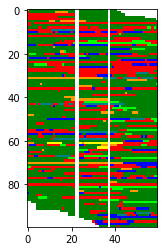

In [8]:
# Downsample if requested
# Original 'voimolevatyollkoodi' status
ids = np.random.choice(fr['henkilotunnus'].unique(), size=100, replace=False)
arr = plot_timelines(fr[fr['henkilotunnus'].isin(ids)], colors= {
        '00': (0  , 128, 128), # D.AQUA : Työllistetty
        '01': (0  , 255, 0  ), # GREEN  : Työssä yleisillä työmarkk.
        '02': (255, 0  , 0  ), # RED    : Työtön
        '03': (255, 153, 0  ), # ORANGE : Lomautettu
        '04': (255, 255, 0  ), # YELLOW : Lyhennetyllä työvkolla
        '05': (0  , 0  , 255), # BLUE   : Työvoiman ulkopuolella
        '06': (255, 0  , 255), # PINK   : Työttömyyseläkkeellä
        '07': (0  , 255, 255), # AQUA   : Työllistym. ed. palvelussa
        '08': (0  , 0  , 128), # D.BLUE : Koulutuksessa
        '09': (0  , 128, 0  ), # D.GREEN: Ei havaintoa (Töissä / Työmarkkinoiden ulkopuolella)
        '10': (255, 255, 255), # WHITE  : Ei havaittavissa (Sensuroitu)
    })

plt.imshow(arr[:,:,:], interpolation='none')


For the purposes of the study, we described the Person x Time observations as binary unemployed / not unemployed states:

Specs: 100 x 57 / 60


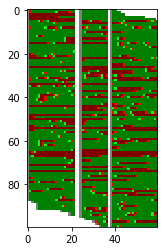

In [9]:

# Binary 'voimolevatyollkoodi' transitions
df = fr[['henkilotunnus', 'vvvvkk', 'voimolevatyollkoodi']].copy()
observable_prev = ((fr['unemployed_prev'] == 1) | (fr['other_prev'] == 1))
df.loc[~observable_prev, 'voimolevatyollkoodi'] = '09'
df.loc[observable_prev & fr['unemployed_prev'] & fr['unemployed'], 'voimolevatyollkoodi'] = '00'
df.loc[observable_prev & fr['unemployed_prev'] & fr['other'], 'voimolevatyollkoodi'] = '01'
df.loc[observable_prev & fr['other_prev'] & fr['other'], 'voimolevatyollkoodi'] = '02'
df.loc[observable_prev & fr['other_prev'] & fr['unemployed'], 'voimolevatyollkoodi'] = '03'
arr = plot_timelines(df[fr['henkilotunnus'].isin(ids)], colors= {
        '00': (128, 0  , 0  ), # D. RED    : Seuraava: Työtön
        '01': (255, 0  , 0  ), # RED  : Seuraava: Muu
        '02': (0  , 128, 0  ), # D. GREEN  : Seuraava: Muu
        '03': (0  , 255, 0  ), # GREEN    : Seuraava: Työtön
        '09': (128, 128, 128), # GREY   : Ei relevantti
        '10': (255, 255, 255), # WHITE  : Ei havaittavissa (Sensuroitu)
    })

plt.imshow(arr[:,:,:], interpolation=None)


## Model description

### General models

This visualization shows the prediction goals of the models. Consider splitting the data set into two parts 'Exit' and 'Entry'.  The 'Exit' is a binary indicator of whether an unemployed person exits unemployment that month and the 'Entry' is a binary indicator of whether a non-unemployed person enters unemployment that month. The 'Status' is simply the binary indicator of whether the person was unemploed at the end of that month:

<img src="transitions.png" alt="Model explanation vis data set" title="" width="650px"/>

Denote the unemployment status of individual $i$ at time $t$ as $x_{i,t}\in\{0,1\}$. Mathematically, we can consider the unemployment status as a realization of a random variable $X_{i,t}∈\{0,1\}$ in a stochastic process $\{X_{i,t},t \geq 0\}$. The probabilities of this stochastic process are things we are interested to predict.

Now, we define three models that predict the following quantities each month:
1. 'Status' is the probability of being unemployed: $s_{i,t}=P(X_{i,t}=1) $.
2. 'Exit' is the probability of exiting unemployment: $q_{i,t}=P(X_{i,t}=0|X_{i,t-1}=1) $.
3. 'Entry' is the probability of entering unemployment: $p_{i,t}=P(X_{i,t}=1|X_{i,t-1}=0) $.



The 'Status' model is fitted to the 'Transitions' data, where we directly predict the unemployment status. The 'Exit' model is fitted to the above 'Exit' data, where we predict the unemployment exits among individuals who were unemployed last month. The 'Entry' model is fitted to the above 'Entry' data, where we predict the unemployment entry among individuals who were not unemployed last month.

In fact, given a certain interesting hypothesis the 'Entry' and 'Exit' do not just predict these events but describe the entire data set...

### Markov Chain assumption

Define the 'state probability vector' as the probability of being non-unemployed or unemployed at a given time:
$$\overline{s}_{i,t}=(P(X_{i,t}=0), P(X_{i,t}=1))$$

Define the 'transition probability matrix' as the probability of moving in or out of unemployment over time given the last known state:
$$T_{i,u \rightarrow t}=
  \left[ {\begin{array}{cc}
   P(X_{i,t}=0|X_{i,u}=0) & P(X_{i,t}=1|X_{i,u}=0) \\
   P(X_{i,t}=0|X_{i,u}=1) & P(X_{i,t}=1|X_{i,u}=1) \\
  \end{array} } \right]
$$

The future unemployment probabilities are predicted by a product of the state vector and transition matrix:
$$\overline{s}_{i,t}=\overline{s}_{i,u}T_{i,u \rightarrow t}$$

Here is an interesting hypothesis: is the stochastic process a Markov Chain? (discrete-time inhomogeneous Markov Chain with heterogeneous transition rates)

Briefly, this idea means that each individual has a monthly probability of 'exiting unemployment' and a monthly probability of 'entering unemployment'. Then each month, if they are unemployed the outcome of exiting unemployment is a coin flip (Bernoulli trial) according to the first probability, and if they are not unemployed the outcome of entering unemployment is a coin flip according to the second probability. This is illustrated nicely in the previous figure. In fact, then the probability of each invidiual unemployment sequence can be described as a simple product of these probabilities:
$$P(\{X_{i,t},t \geq 0\})
=P(X_{i,t},X_{i,t-1},…,X_{i,0} )
=P(X_{i,t} |X_{i,t-1} )P(X_{i,t-1} |X_{i,t-2} )…P(X_{i,1} |X_{i,0} )P(X_{i,0} )$$

Now, define the following one-step transition probability matrix given the previous probabilities:

$$T_{i,t}=
  \left[ {\begin{array}{cc}
   1-p_{i,t} & p_{i,t} \\
   q_{i,t} & 1-q_{i,t} \\
  \end{array} } \right]
$$


In a Markov Chain, the transition probability matrix is a product of one-step transition matrices:
$$ T_{i,u \rightarrow t} \prod_{j=s+1}^{t} T_{i,j} $$

The future state can then be predicted by repeatedly multiplying the initial state probabilities with these matrices:
$$ \overline{s}_{i,t} = \overline{s}_{i,u}T_{i,u + 1}T_{i,u + 2}...T_{i,t}$$

Here is a very interesting result of Markov Chains. If the transition probabilities are constant, say $q_{i,t}=q_i$ and $p_{i,t}=p_i$, regardless of the initial state the process converges over time to the 'steady state' probabilities:
$$ \text{lim}_{t\rightarrow\infty}\overline{s}_{i,t} = 
  \left[ {\begin{array}{cc}
   \frac{q_i}{q_i+p_i} & \frac{p_i}{q_i+p_i}\\
  \end{array} } \right]$$

This means that if we do not have any previous observations, it makes sense to use the steady state probabilities as the initial state $ \overline{s}_{i,0} = \overline{s}_{i,\infty}$. Furthermore this implies that over time, every individual is predicted to spend this proportion of their working life in unemployment. 

It is a valid question to ask whether the 'Markov chain' assumption is realistic, i.e. if the persons can really be described as a stochastic process given the unemployment exit and entry probabilities. Lets generate some data from Markov Chains and see how they look like. Lets say for example that the probabilities are both Beta-distributed, which we specify with some realistic values for the mean and variance. First, we sample the person-specific exit and entry probabilities and then generate their unemployment history by simulating the unemployment status as a Markov Chain with these transition probabilities. 

In [10]:
from simulation import Beta, sample_data, plot_data_states, plot_rates

# Entry and exit rates as Beta(mean, var) distributed
mean_p, var_p = 0.0125, 0.02**2
mean_q, var_q = 0.07, 0.02**2
P = Beta(mean_p, var_p)
Q = Beta(mean_q, var_q)

# Generate a heterogeneous data set given samples (N), time (T)
N, T = 100, 120
data, rates = sample_data(N, T, P, Q)

The resulting data set has the same format as our data set:

In [11]:
data[['sample', 'time', 'unemployed']].head()

,sample,time,unemployed
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0


The resulting data set looks a lot like real unemployment data:

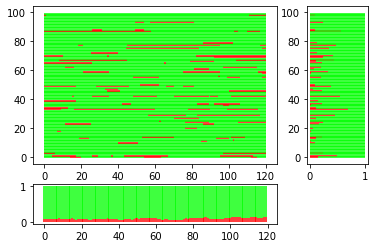

In [12]:
plot_data_states(data)
#plot_rates(P, Q, rates['entry'], rates['exit'])

The bottom panel visualizes the 'unemployment rate', which is defined as the percentage of individuals unemployed each month. This typically reported in the news and various reports when people are interested about unemployment. However, the right panel visualizes a type of 'individual unemployment rate', which is the proportion of time the person was unemployed. The steady state probabilities imply that over time (as the follow-up is longer and longer) this converges to a given number, which means that each individual can be predicted to have a certain lifetime occurance of unemployment. Very cool!

## Process data set

The anonymized person identifier has a different number of observations for each individual. It is possible to have a maximum of 57 observations unless the person is censored at some time points because they were under 18 or over 65:

In [13]:
fr['henkilotunnus'].value_counts().head()

20470    57
6505     57
12655    57
59764    57
47486    57
Name: henkilotunnus, dtype: int64

The time identifier is the time point when the registry was sampled:

In [14]:
#fr['vvvvkk'] = pd.Categorical(fr['vvvvkk'])
fr['vvvvkk'] = pd.to_datetime(fr['vvvvkk'])
fr['vvvvkk'].value_counts().sort_index().head()

2013-01-01    18573
2013-02-01    18627
2013-03-01    18679
2013-04-01    18727
2013-05-01    18770
Name: vvvvkk, dtype: int64

The age describes the person's age in categorical 5 year buckets:

In [15]:
# Assign age to 5 year buckets
fr['ika'] = pd.cut(fr['ika'], bins=[18,20,25,30,35,40,45,50,55,60,65], right=False, include_lowest=True)
fr['ika'] = pd.Categorical(fr['ika'].astype(str), categories=['%s' % c for c in fr['ika'].cat.categories])
fr['ika'].value_counts().sort_index()

[18, 20)     47569
[20, 25)    169007
[25, 30)    149407
[30, 35)    135869
[35, 40)    117712
[40, 45)    101663
[45, 50)    102406
[50, 55)     98336
[55, 60)     95771
[60, 65)     84401
Name: ika, dtype: int64

The other features are described as codes in the data set, so we load and attach the human readable descriptions (in finnish) from a file:

In [16]:
# Read labels corresponding to codes and print value counts
fr_code = pd.read_csv('data_koodit.csv', encoding='utf-8', sep=';')
for key, tfr in fr_code.groupby('column'):
    ts = tfr.set_index('key')['value']
    if key in fr:
        fr[key] = pd.Categorical(fr[key].map(ts), categories=pd.unique(ts))

Then translate them into english:

In [17]:
fr.rename(columns = {'supukoodi':'Gender', 'tyokokemuskoodi': 'Work experience', 'ika': 'Age', 
                     'koulutusastekoodi_2': 'Level of education', 'koulutusalakoodi_1': 'Field of education'}, inplace=True)

Gender is a categorical variable:

In [18]:
fr['Gender'] = fr['Gender'].map({'Mies':'Male', 'Nainen':'Female'})
fr['Gender'].value_counts().sort_index()

Male      584258
Female    517883
Name: Gender, dtype: int64

Work experience is a categorical variable:

In [19]:
fr['Work experience'] = fr['Work experience'].map({'ei työkokemusta': 'None', 'vähän työkokemusta': 'Little',
                                                   'riittävästi työkokemusta': 'Sufficient'})
fr['Work experience'].value_counts().sort_index()

None          356959
Little        312812
Sufficient    432370
Name: Work experience, dtype: int64

Level of education is a categorical variable:

In [20]:
fr['Level of education'] = fr['Level of education'].map({'Varhaiskasvatus (3 vuotta täyttäneet) ja esiopetus': 'Early education',
                     'Perusopetus, vuosiluokat 1-6': 'Basic Education 1-6', 
                     'Perusopetus, vuosiluokat 7-9': 'Basic Education 7-9',
                     'Lukiokoulutus': 'Gymnasium', 
                     'Ammatillinen peruskoulutus': 'Vocational Basic', 
                     'Ammattitutkinto': 'Vocational',
                     'Opistoaste': 'Vocational (depreceated)', 
                     'Ammatillinen korkea-aste': 'Vocational higher',
                     'Ammattikorkeakoulututkinto': 'Bachelors (Applied Sciences)', 
                     'Ylempi ammattikorkeakoulututkinto': 'Masters (Applied Sciences)', 
                     'Alempi korkeakoulututkinto': 'Bachelors (University)',
                     'Ylempi korkeakoulututkinto': 'Masters (University)',
                     'Lääkärien erikoistumiskoulutus': 'Medical Specialization', 
                     'Lisensiaatintutkinto': 'Licensiate',
                     'Tohtorintutkinto': 'Doctorate (University)', 
                     'Koulutusaste tuntematon': 'Unknown'})
fr['Level of education'].value_counts().sort_index()

Bachelors (Applied Sciences)     65068
Bachelors (University)           26806
Basic Education 1-6              47243
Basic Education 7-9             179516
Doctorate (University)            4869
Early education                   1021
Gymnasium                       115372
Licensiate                        1390
Masters (Applied Sciences)        4302
Masters (University)             77995
Medical Specialization             570
Unknown                          37221
Vocational                       55565
Vocational (depreceated)         72287
Vocational Basic                397034
Vocational higher                15882
Name: Level of education, dtype: int64

Field of education is a categorical variable:

In [21]:
fr['Field of education'] = fr['Field of education'].map({'Yleissivistävä koulutus': 'General Education', 
                     'Kasvatusalat': 'Education',
                     'Humanistiset ja taidealat': 'Humanities and Arts', 
                     'Yhteiskunnalliset alat': 'Social Studies',
                     'Kauppa, hallinto ja oikeustieteet': 'Economics and Law', 
                     'Luonnontieteet': 'Natural Sciences',
                     'Tietojenkäsittely ja tietoliikenne (ICT)': 'Computer Science and IT', 
                     'Tekniikan alat': 'Engineering',
                     'Maa- ja metsätalousalat': 'Agriculture and Forestry', 
                     'Terveys- ja hyvinvointialat': 'Health and Welfare',
                     'Palvelualat':'Services', 
                     'Muut tai tuntemattomat koulutusalat': 'Unknown'})
fr['Field of education'].value_counts().sort_index()

General Education           360188
Education                    15013
Humanities and Arts          66067
Social Studies               14422
Economics and Law           102463
Natural Sciences             14511
Computer Science and IT      39426
Engineering                 240234
Agriculture and Forestry     22490
Health and Welfare           73219
Services                    104040
Unknown                      50068
Name: Field of education, dtype: int64

The categorical features are converted into a binary indicators (one-hot encoding):

In [22]:
col_classes = ['henkilotunnus', 'vvvvkk', 'Gender', 'Work experience', 'Age', 'Level of education', 'Field of education']
all_classes = OrderedDict([(col, np.sort(fr[col].unique())) for col in col_classes])
col_onehots = ['%s=%s' % (feature, category) for feature in all_classes for category in all_classes[feature]]
onehot = preprocessing.OneHotEncoder(categories=list(all_classes.values()))

## Train models

We use use a special AUC validation strategy where we take into account the fact that many observations can come from the same unemployed person. The AUC is time-stratified in the sense that we calculate the AUC by comparing observations at each time point, which means that different observations from the same person are not compared with each other:

In [23]:
# https://www.ibm.com/developerworks/community/blogs/jfp/entry/Fast_Computation_of_AUC_ROC_score?lang=en
def fast_auc( Y, P, split=False):
    y_true = np.asarray(Y)
    y_true = y_true[np.argsort(P)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    npairs = nfalse * (n - nfalse)
    return auc / npairs if not split else (auc, npairs)

# Compute time-stratified AUC
def auc_stratified(Y, P, T, subset=None):
    if not subset is None:
        Y, P, T = Y[subset], P[subset], T[subset]
    fr = pd.DataFrame({'Y': np.array(Y), 'P': np.array(P), 'T': np.array(T)})
    nc, n = 0, 0
    for T, s in fr.groupby('T'):
        if len(s['Y'].unique()) > 1:
            nc_, n_ = fast_auc(s['Y'], s['P'], split=True)
            nc += nc_
            n += n_
    return nc/n


def auc_t(Y, P, T, subset=None):
    if not subset is None:
        Y, P, T = Y[subset], P[subset], T[subset]
    fr = pd.DataFrame({'Y': np.array(Y), 'P': np.array(P), 'T': np.array(T)})
    auc = fr.groupby('T').apply(lambda s: metrics.roc_auc_score(s['Y'], s['P']) if len(s['Y'].unique()) > 1 else np.nan)
    return auc


### Unemployment exit

The first model is used to predict 'unemployment exit'. There are two states: unemployed (0/1) and other (0/1), which are each other's complements. The model uses a subset of data where the previous unemployment state was unemployed (unemployed=1) and aims to predict whether the person exited unemployment or not (other=1/0) that month.

In [24]:
train = (fr['dataset'] == 'Train') & (fr['unemployed_prev'] == 1)
event = 'other'

# Train
X_train = onehot.fit_transform(fr[train][col_classes])
Y_train = fr[train][event]
clf_exit = LogisticRegression(random_state=0, solver='saga', max_iter=1000)
clf_exit.fit(X_train, Y_train)

# Test
X_test = onehot.fit_transform(fr[col_classes])
Y_test = fr[event]
fr['exit'] = clf_exit.predict_proba(X_test)[:, 1]

C:\Users\mvil4\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The AUC at each month indicates that the test set predictions are considerably more difficult, probably because the unemployment exists do not indicate large person specific differences in exiting unemployment that are not explained by the covariates. The cold start performance is modest, indicating that the features have some information but there is significant randomness in who finds a job and who doesn't:

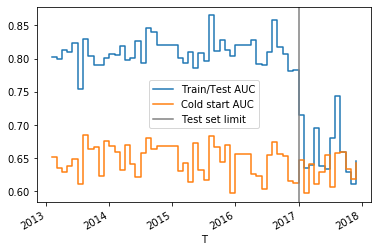

In [25]:
Y, T, P = fr['other'], fr['vvvvkk'], fr['exit']
both_exit = auc_t(Y, P, T, subset=(fr['dataset'] != 'Cold') & (fr['unemployed_prev'] == 1))
cold_exit = auc_t(Y, P, T, subset=(fr['dataset'] == 'Cold') & (fr['unemployed_prev'] == 1))
both_exit.plot(drawstyle='steps-post', label='Train/Test AUC')
cold_exit.plot(drawstyle='steps-post', label='Cold start AUC')
plt.axvline(pd.Timestamp('2017-01-01'), color='grey', label='Test set limit')
plt.legend()

### Unemployment entry

The first model is used to predict 'unemployment entry'. There are two states: unemployed (0/1) and other (0/1), which are each other's complements. The model uses a subset of data where the previous unemployment state was not unemployed (other=1) and aims to predict whether the person entered unemployment or not (unemployed=1/0) that month.

In [26]:
train = (fr['dataset'] == 'Train') & (fr['other_prev'] == 1)
event = 'unemployed'

# Train
X_train = onehot.fit_transform(fr[train][col_classes])
Y_train = fr[train][event]
clf_entry = LogisticRegression(random_state=0, solver='saga', max_iter=1000)
clf_entry.fit(X_train, Y_train)

# Test
X_test = onehot.fit_transform(fr[col_classes])
Y_test = fr[event]
fr['entry'] = clf_entry.predict_proba(X_test)[:, 1]

C:\Users\mvil4\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The AUC at each month indicates that the test set predictions are slightly more difficult, which indicates that there could be interesting differences between people in becoming unemployed again that cannot be explained by the features. The cold start performance is again modest, indicating that the features have some information but there is a lot of randomness in who becomes unemployed:

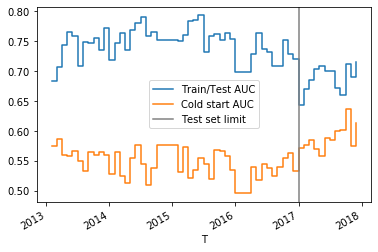

In [27]:
Y, T, P = fr['unemployed'], fr['vvvvkk'], fr['entry']
both_entry = auc_t(Y, P, T, subset=(fr['dataset'] != 'Cold') & (fr['other_prev'] == 1))
cold_entry = auc_t(Y, P, T, subset=(fr['dataset'] == 'Cold') & (fr['other_prev'] == 1))
both_entry.plot(drawstyle='steps-post', label='Train/Test AUC')
cold_entry.plot(drawstyle='steps-post', label='Cold start AUC')
plt.axvline(pd.Timestamp('2017-01-01'), color='grey', label='Test set limit')
plt.legend()

### Unemployment prevalence

The third model is used to predict 'unemployment status' (or 'prevalence') directly. The model uses all of the data set and aims to predict whether the person was unemployed or not (unemployed=1/0) that month.

In [28]:
train = (fr['dataset'] == 'Train')
event = 'unemployed'

# Train
X_train = onehot.fit_transform(fr[train][col_classes])
Y_train = fr[train][event]
clf_prevalence = LogisticRegression(random_state=0, solver='saga', max_iter=1000)
clf_prevalence.fit(X_train, Y_train)

# Test
X_test = onehot.fit_transform(fr[col_classes])
Y_test = fr[event]
fr['prevalence'] = clf_prevalence.predict_proba(X_test)[:, 1]

The AUC at each month indicates that the test set predictions are quite good, which indicates that there are person-specific differences beyond the features that predict whether someone is unemployed. The cold start performance is once more modest, indicating that the features have some information but there is a lot of randomness in who is unemployed:

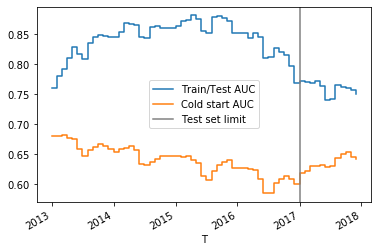

In [29]:
Y, T, P = fr['unemployed'], fr['vvvvkk'], fr['prevalence']
both_prevalence = auc_t(Y, P, T, subset=(fr['dataset'] != 'Cold'))
cold_prevalence = auc_t(Y, P, T, subset=(fr['dataset'] == 'Cold'))
both_prevalence.plot(drawstyle='steps-post', label='Train/Test AUC')
cold_prevalence.plot(drawstyle='steps-post', label='Cold start AUC')
plt.axvline(pd.Timestamp('2017-01-01'), color='grey', label='Test set limit')
plt.legend()

Remember that the 'Exit' and 'Entry' models actually imply the unemployment status as a Markov Chain model? We can use the implied steady state probabilities from this model to predict the unemployment status:

In [30]:
fr['steady'] = fr['entry'] / (fr['entry'] + fr['exit'])

The AUC at each month is quite similar:

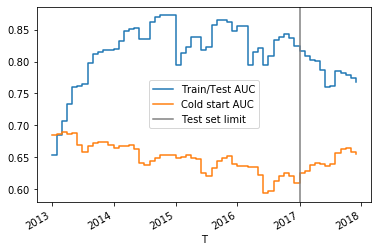

In [31]:
Y, T, P = fr['unemployed'], fr['vvvvkk'], fr['steady']
both_steady = auc_t(Y, P, T, subset=(fr['dataset'] != 'Cold'))
cold_steady = auc_t(Y, P, T, subset=(fr['dataset'] == 'Cold'))
both_steady.plot(drawstyle='steps-post', label='Train/Test AUC')
cold_steady.plot(drawstyle='steps-post', label='Cold start AUC')
plt.axvline(pd.Timestamp('2017-01-01'), color='grey', label='Test set limit')
plt.legend()

### Summary

Finally, we can average the time-stratified AUCs of different models to get the following summary table:

In [32]:
Y, T, P = fr['other'], fr['vvvvkk'], fr['exit']
train_exit = auc_stratified(Y, P, T, subset=(fr['dataset'] == 'Train') & (fr['unemployed_prev'] == 1))
test_exit = auc_stratified(Y, P, T, subset=(fr['dataset'] == 'Test') & (fr['unemployed_prev'] == 1))
cold_exit = auc_stratified(Y, P, T, subset=(fr['dataset'] == 'Cold') & (fr['unemployed_prev'] == 1))

Y, T, P = fr['unemployed'], fr['vvvvkk'], fr['entry']
train_entry = auc_stratified(Y, P, T, subset=(fr['dataset'] == 'Train') & (fr['other_prev'] == 1))
test_entry = auc_stratified(Y, P, T, subset=(fr['dataset'] == 'Test') & (fr['other_prev'] == 1))
cold_entry = auc_stratified(Y, P, T, subset=(fr['dataset'] == 'Cold') & (fr['other_prev'] == 1))

Y, T, P = fr['unemployed'], fr['vvvvkk'], fr['prevalence']
train_status = auc_stratified(Y, P, T, subset=(fr['dataset'] == 'Train'))
test_status = auc_stratified(Y, P, T, subset=(fr['dataset'] == 'Test'))
cold_status = auc_stratified(Y, P, T, subset=(fr['dataset'] == 'Cold'))

Y, T, P = fr['unemployed'], fr['vvvvkk'], fr['steady']
train_steady = auc_stratified(Y, P, T, subset=(fr['dataset'] == 'Train'))
test_steady = auc_stratified(Y, P, T, subset=(fr['dataset'] == 'Test'))
cold_steady = auc_stratified(Y, P, T, subset=(fr['dataset'] == 'Cold'))

auc = pd.DataFrame({'Train': [train_exit, train_entry, train_status, train_steady], 
                    'Test': [test_exit, test_entry, test_status, test_steady], 
                    'Cold': [cold_exit, cold_entry, cold_status, cold_steady]},
                    index=['Exit', 'Entry', 'Prevalence', 'Steady state']).round(2)
print(auc)

              Train  Test  Cold
Exit           0.81  0.67  0.65
Entry          0.75  0.69  0.55
Prevalence     0.84  0.76  0.64
Steady state   0.82  0.79  0.65


### Markov Chain

The 'Markov Chain' assumption can be used to predict x steps forward, given that we know the previous unemployment status:

In [33]:
vvvvkk = pd.to_datetime(pd.period_range('2013-01-01', '2017-12-01', freq='M').to_timestamp())
fr = fr.groupby('henkilotunnus').apply(lambda fr: fr.set_index('vvvvkk').reindex(vvvvkk))
fr = fr.drop('henkilotunnus', axis=1)
fr = fr.reset_index()
fr.rename(columns={'level_1': 'vvvvkk'}, inplace=True)

fr['unemployed_prev1'] = fr.groupby('henkilotunnus')['unemployed'].apply(lambda s: s.shift(1))
fr['entry_prev1'] = fr.groupby('henkilotunnus')['entry'].apply(lambda s: s.shift(1))
fr['exit_prev1'] = fr.groupby('henkilotunnus')['exit'].apply(lambda s: s.shift(1))
fr['unemployed_prev3'] = fr.groupby('henkilotunnus')['unemployed'].apply(lambda s: s.shift(3))
fr['entry_prev3'] = fr.groupby('henkilotunnus')['entry'].apply(lambda s: s.shift(3))
fr['exit_prev3'] = fr.groupby('henkilotunnus')['exit'].apply(lambda s: s.shift(3))
fr['unemployed_prev12'] = fr.groupby('henkilotunnus')['unemployed'].apply(lambda s: s.shift(12))
fr['entry_prev12'] = fr.groupby('henkilotunnus')['entry'].apply(lambda s: s.shift(12))
fr['exit_prev12'] = fr.groupby('henkilotunnus')['exit'].apply(lambda s: s.shift(12))

In [34]:
from numpy.linalg import matrix_power

# Computes the predicted state based on previous state 'shift' time points ago
def markov_state(fr, shift):
    cols = ['unemployed_prev%d' % shift, 'exit_prev%d' % shift, 'entry_prev%d' % shift]
    
    Y_ = []
    for idx, (S1, P10, P01) in fr[cols].iterrows():
        #print(S1, P10, P01, np.isnan(S1))
        S = np.array([[1.0-P01, P01], [P10, 1.0-P10]])
        if not np.isnan(S1):
            S1 = int(S1)
            Y = matrix_power(S, shift)[S1,1]
        else:
            Y = np.nan
        Y_.append(Y)
    P = pd.DataFrame({('unemployed_%d' % shift) : Y_}, index=fr['vvvvkk'])
    return(P)

pred1 = fr.groupby('henkilotunnus').apply(lambda fr: markov_state(fr, 1))
pred1 = pred1.reset_index()

pred3 = fr.groupby('henkilotunnus').apply(lambda fr: markov_state(fr, 3))
pred3 = pred3.reset_index()

pred12 = fr.groupby('henkilotunnus').apply(lambda fr: markov_state(fr, 12))
pred12 = pred12.reset_index()

fr = fr.merge(pred1, how='left')
fr = fr.merge(pred3, how='left')
fr = fr.merge(pred12, how='left')

This assumption helps to increase the predictive accuracy by a large margin, assuming that we know the unemployment status some months ago. If we know the previous unemployment status, it is very easy to predict the current month as most people remain unemployed. Even 3 months on the predictions are very good, but over time we lose the utility of knowing the previous unemployment status. At 12 months they are similar to the steady state predictions:

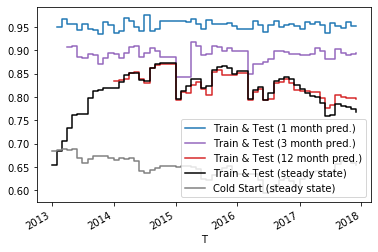

In [35]:
Y = fr['unemployed']
T = fr['vvvvkk']

# Train Markov (1)
P = fr['unemployed_1']
auc_df = auc_t(Y, P, T, subset=((fr['dataset'] == 'Train') | (fr['dataset'] == 'Test')) & ~P.isnull())
auc_df.plot(drawstyle='steps-post', label='Train & Test (1 month pred.)', color='#1f77b4')

# Train Markov (3)
P = fr['unemployed_3']
auc_df = auc_t(Y, P, T, subset=((fr['dataset'] == 'Train') | (fr['dataset'] == 'Test')) & ~P.isnull())
auc_df.plot(drawstyle='steps-post', label='Train & Test (3 month pred.)', color='#9467bd')

# Train Markov (12)
P = fr['unemployed_12']
auc_df = auc_t(Y, P, T, subset=((fr['dataset'] == 'Train') | (fr['dataset'] == 'Test')) & ~P.isnull())
auc_df.plot(drawstyle='steps-post', label='Train & Test (12 month pred.)', color='#d62728')

# Train Steady State
P = fr['entry'] / (fr['entry'] + fr['exit'])
auc_df = auc_t(Y, P, T, subset=(fr['dataset'] == 'Train') | (fr['dataset'] == 'Test'))
auc_df.plot(drawstyle='steps-post', label='Train & Test (steady state)', color='black')

# Cold Start Steady State
P = fr['entry'] / (fr['entry'] + fr['exit'])
auc_df = auc_t(Y, P, T, subset=(fr['dataset'] == 'Cold'))
auc_df.plot(drawstyle='steps-post', label='Cold Start (steady state)', color='grey')

plt.legend()

## Interpreting the effects of features

The cofficients in a linear model (logistic regression) can be interpreted to understand how different features influence the predictions. Lets 

In [36]:
vi, v = clf_exit.intercept_, clf_exit.coef_.flatten()
#v = v + vi
ui, u = clf_entry.intercept_, clf_entry.coef_.flatten()
#u = u + ui
p = u - v

We now construct the following table of how the features affect each of the three models and visualize the impact of each feature:

In [37]:
coefs = pd.DataFrame({'Entry': u, 'Exit': v, 'Prevalence': p}, index = col_onehots)
coefs['Term'] = [s.split('=')[0] for s in coefs.index]
coefs['Value'] = [s.split('=')[1] for s in coefs.index]
coefs.index = np.arange(len(coefs)) + 1
coefs

,Entry,Exit,Prevalence,Term,Value
1,0.000000,0.000000,0.000000,henkilotunnus,83
2,0.000000,-0.686634,0.686634,henkilotunnus,85
3,0.000000,0.000000,0.000000,henkilotunnus,87
4,0.000000,0.000000,0.000000,henkilotunnus,95
5,0.000000,0.000000,0.000000,henkilotunnus,97
...,...,...,...,...,...
20096,0.057895,-0.199196,0.257091,Field of education,Humanities and Arts
20097,-0.099546,-0.143801,0.044255,Field of education,Natural Sciences
20098,-0.016132,-0.075797,0.059666,Field of education,Services
20099,-0.232307,-0.048595,-0.183712,Field of education,Social Studies


The coefficients suggest the following:
1. Males have a slightly lower exit rate but same entry rate, resulting in a little bit more unemployment.
2. Work experience helps with more experience associated to both higher exit rate and lower entry rate resulting in less unemployment.
3. Increasing age related to significantly higher odds of unemployment, because it becomes a lot harder to exit unemployment and slightly more likely to become unemployed.
4. Having only basic education increases unemployment, and university education may sometimes be slightly better than vocational education.
5. Field of education has an impact. At the time of study the most demand was in health and welfame, and the least in IT and natural sciences. It just happens that Nokia had big layoffs in the local area...

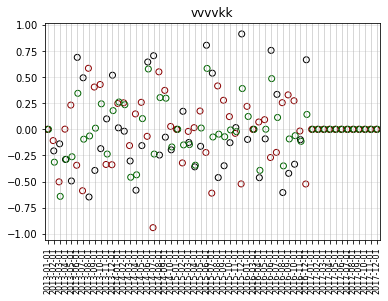

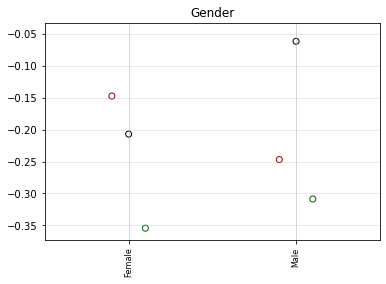

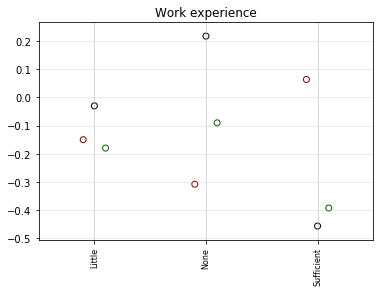

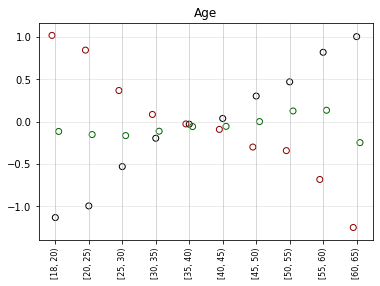

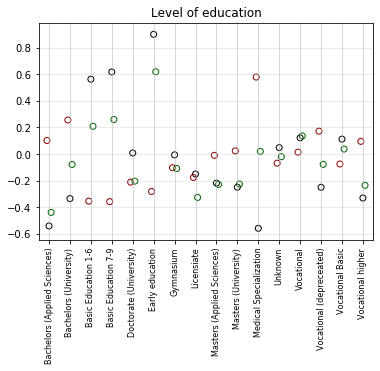

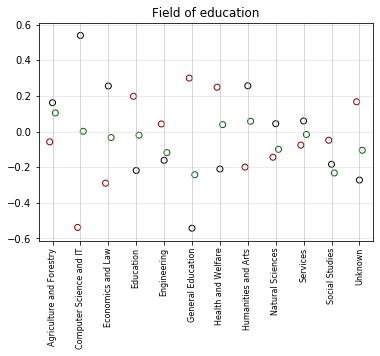

In [38]:
# Plot coefficients for all three models: rate, exit, entry
for i, (coef, df) in enumerate(coefs.groupby('Term', sort=False)):
    if coef != 'henkilotunnus':
        x = pd.to_datetime(df['Value']).dt.strftime('%Y-%m-%d') if coef == 'vvvvkk' else df['Value']
        idx = np.arange(len(x))
        fig, ax = plt.subplots(1, 1)
        # Covariate value x model table of effects (+-SE)
        ax.scatter(idx, df['Prevalence'], facecolors='none', edgecolors='black', marker='o', label='Prevalence')
        ax.scatter(idx-0.1, df['Exit'], facecolors='none', edgecolors='darkred', marker='o', label='Exit')
        ax.scatter(idx+0.1, df['Entry'], facecolors='none', edgecolors='darkgreen', marker='o', label='Entry')
        ax.set_xticks(idx)
        ax.set_xticklabels(x, rotation=90, fontsize=8)
        ax.set_xlim([min(idx)-0.5, max(idx)+0.5])
        ax.grid(which='major', axis='y', linestyle='-', linewidth=0.5, alpha=0.5)
        ax.grid(which='minor', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.grid(which='major', axis='x', linestyle='-', linewidth=0.5)
        ax.set_title(coef)


When the model has observed unemployment history of a person (Train set), we can also learn the person specific effect to the unemployment entry or exit probability that is not explained by the features:

In [39]:
cold_ids = fr.loc[fr['dataset'] == 'Cold', 'henkilotunnus'].unique()
intercepts = coefs[(coefs['Term'] == 'henkilotunnus')]
intercepts = intercepts[~intercepts['Value'].astype(int).isin(cold_ids)]

We see that people differ in their own entry and exit rates, and there might be some correlation between higher risk of entry and lower risk of exit:

Text(0, 0.5, 'Exit')

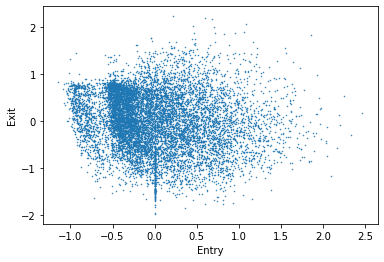

In [40]:
plt.scatter(intercepts['Entry'], intercepts['Exit'], marker='.', s=1)
plt.xlabel('Entry')
plt.ylabel('Exit')

The implied unemployment prevalence also varies quite a lot by the person, even after accounting for their generic features. Maybe there are differences in motivation, demand for specific jobs, life challenges, etc. that we could include to improve the cold start model?

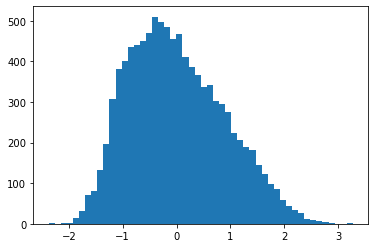

In [41]:
_= plt.hist(intercepts['Prevalence'], bins=50)

## Widget

We now make a simple widget that can be used to get predictions for an individual in real time. These features specify the individual:

In [42]:
from ipywidgets import interact

choose = ['Gender', 'Work experience', 'Age', 'Level of education', 'Field of education']
choices = {coef: list(values.unique()) for coef, values in coefs.groupby('Term')['Value'] if coef in choose}
#choices

We pick a random month and compare the predictions for the given individual relative to all others observed that month:

In [43]:
from sklearn.preprocessing import QuantileTransformer
ref = fr.loc[(fr['vvvvkk'] == '2016-12-01') & (fr['dataset'] == 'Cold'), ['exit', 'entry', 'prevalence']].dropna()
qt = QuantileTransformer(random_state=0)
qt.fit_transform(ref)

array([[0.03103103, 0.16366366, 0.96846847],
       [0.05255255, 0.05805806, 0.92092092],
       [0.03103103, 0.16366366, 0.96846847],
       ...,
       [0.48748749, 0.61161161, 0.22671125],
       [0.77050114, 0.03203203, 0.1070993 ],
       [0.9862916 , 0.14314314, 0.0914993 ]])

The widget asks for the 5 different features and gives a prediction of how you compare to other people. Top % means you belong to the given quantile in terms of unemployment risk, where Top 0% is the lowest risk and Top 100% is the highest risk.

In [44]:
def pick(**args):
    spec = pd.DataFrame(args, index=[0])
    spec['henkilotunnus'] = cold_ids[0]
    spec['vvvvkk'] = pd.Timestamp('2016-12-01')

    x_test = onehot.fit_transform(spec[col_classes])
    y_exit = clf_exit.predict_proba(x_test)[:, 1][0]
    y_entry = clf_entry.predict_proba(x_test)[:, 1][0]
    y_prevalence = clf_prevalence.predict_proba(x_test)[:, 1][0]
    y = np.array([[y_exit, y_entry, y_prevalence]])
    y = qt.transform(y)
    y_exit, y_entry, y_prevalence = 1.0-y[0,0], y[0,1], y[0,2]
    #print(y_exit, y_entry, y_prevalence)
    plt.figure(figsize=(6,1))
    plt.title('Your risk of unemployment events is:')
    plt.text(1,1.5, 'Exit', horizontalalignment='center', fontsize='large')
    plt.text(2,1.5, 'Entry', horizontalalignment='center', fontsize='large')
    plt.text(3,1.5, 'Prevalence', horizontalalignment='center', fontsize='large')
    plt.text(1,1,'Top %.1f%%' % (y_exit*100), horizontalalignment='center', fontsize='x-large')
    plt.text(2,1,'Top %.1f%%' % (y_entry*100), horizontalalignment='center', fontsize='x-large')
    plt.text(3,1,'Top %.1f%%' % (y_prevalence*100), horizontalalignment='center', fontsize='x-large')
    plt.xlim(0,4)
    plt.ylim(0.5,2)
    plt.axis('off')




In [45]:
_ = interact(pick, **choices)

interactive(children=(Dropdown(description='Age', options=('[18, 20)', '[20, 25)', '[25, 30)', '[30, 35)', '[3…

It looks like a 30-35 year old male computer scientist with a PhD and some work experience is significantly slower in finding a job (Top 77%) but quite unlikely to become unemployed relative to others (Top 9%), which implies that they are about the median person in terms of total amount of unemployment over their lifetime (Top 52%). That is quite comforting, and suggests that I should not worry too much...